In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

# DATA LOAD

In [ ]:
train_dir = 'archive/train'
test_dir = 'archive/test'
val_dir = 'archive/validation'

In [ ]:
batch_size = 32
image_size = 160

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size=batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [ ]:
class_name = train_data.class_names
print(class_name)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


image samples visualization

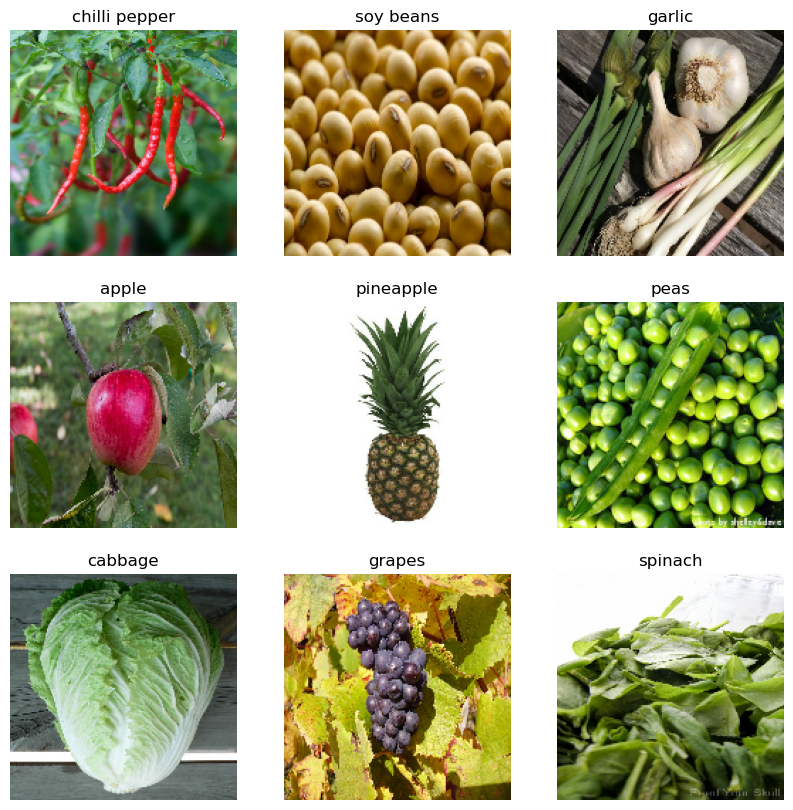

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')


check the shape of data

In [ ]:
for image_batch, label_batch in train_data:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


make data between 0-1

In [ ]:
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  return image, label

In [ ]:
train = train_data.map(format)
validation = val_data.map(format)

In [ ]:
for format_image_batch, format_label_batch in train:
  print(format_image_batch.shape)
  print(format_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [ ]:
format_first_image = format_image_batch[0]
print(np.min(format_first_image), np.max(format_first_image))

0.0 1.0


# MODELING

use MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (image_size, image_size, 3),
                                               include_top = False,
                                               weights = 'imagenet')

9406464/9406464 [==============================] - 2s 0us/step


size check

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 36)


In [ ]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer
])

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train,
                    epochs=20,
                    validation_data=validation)

Epoch 1/20
98/98 [==============================] - 134s 1s/step - loss: 1.9145 - accuracy: 0.5091 - val_loss: 0.8380 - val_accuracy: 0.7379
Epoch 2/20
98/98 [==============================] - 130s 1s/step - loss: 0.6029 - accuracy: 0.8424 - val_loss: 0.5818 - val_accuracy: 0.8120
Epoch 3/20
98/98 [==============================] - 129s 1s/step - loss: 0.2834 - accuracy: 0.9326 - val_loss: 0.4593 - val_accuracy: 0.8689
Epoch 4/20
98/98 [==============================] - 129s 1s/step - loss: 0.1616 - accuracy: 0.9663 - val_loss: 0.3353 - val_accuracy: 0.8917
Epoch 5/20
98/98 [==============================] - 129s 1s/step - loss: 0.0927 - accuracy: 0.9791 - val_loss: 0.3107 - val_accuracy: 0.8946
Epoch 6/20
98/98 [==============================] - 128s 1s/step - loss: 0.0730 - accuracy: 0.9814 - val_loss: 0.3079 - val_accuracy: 0.9117
Epoch 7/20
98/98 [==============================] - 129s 1s/step - loss: 0.0545 - accuracy: 0.9862 - val_loss: 0.2733 - val_accuracy: 0.9145
Epoch 8/20
98

# MODEL EVALUATE

In [ ]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

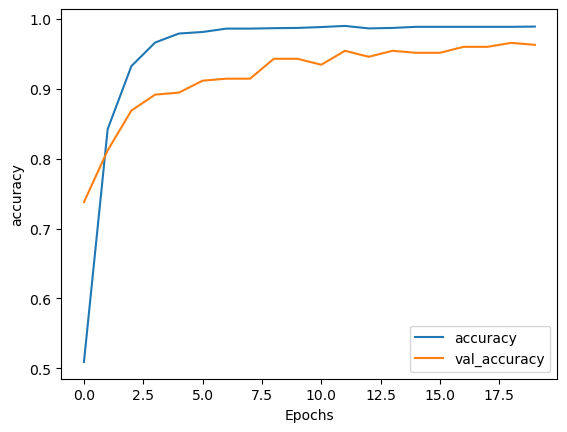

In [ ]:
plot_graghs(history, 'accuracy')

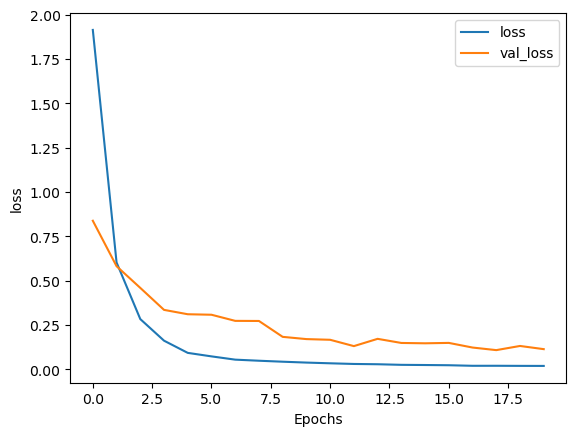

In [ ]:
plot_graghs(history, 'loss')

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(image_size, image_size),
                                                                batch_size = batch_size,
                                                                shuffle=False)

Found 359 files belonging to 36 classes.


# TEST

In [ ]:
test = test_data.map(format)

In [ ]:
result = model.evaluate(test)
print("Test loss, Test accuracy : ", result)

12/12 [==============================] - 4s 307ms/step - loss: 0.1112 - accuracy: 0.9638
Test loss, Test accuracy :  [0.11124143749475479, 0.9637883305549622]
